In [1]:
import random
import numpy as np
import regiorust as rr
from src.redcap import Redcap
from src.SCT import SCT
import pandas as pd
import time
import matplotlib.pyplot as plt
from src.artificial_regions import *

In [46]:
class Evaluation:
    
    def __init__(self,vertices_values,size,k,n_centers,delta,n,sct_method,W,cutoff,h_tot,b_h_tot,R,b_R,true_R,proved_exact,h_r,b_h_r,del_e,b_del_e,times,b_times):
        self.vertices = vertices_values
        self.size = size
        self.N = size*size
        self.k = k
        self.n_centers = n_centers
        self.delta = delta
        self.n = n
        self.sct_method = sct_method
        self.W = W
        self.cutoff = cutoff
        self.h_tot = h_tot
        self.baseline_h_tot = b_h_tot
        self.regions = R
        self.baseline_regions = b_R
        self.true_regions = true_R
        self.true_h_tot = self.compute_true_h_tot()
        self.proved_exact = proved_exact
        self.h_regions = h_r
        self.baseline_h_regions = b_h_r
        self.deleted_edges = del_e
        self.baseline_deleted_edges = b_del_e
        self.times = times
        self.baseline_times = b_times
    
    def mean_h_tot_ratio(self):
        return (np.array(self.h_tot)/np.array(self.baseline_h_tot)).mean()
    
    def compute_true_h_tot(self):
        true_h_tot = []
        for d in range(self.n):
            h_tot = 0.0
            regions = [[] for _ in range(self.k)]
            for i,r in enumerate(self.true_regions[d]):
                regions[int(r-1)].append(i)
            for region in regions:
                values = [self.vertices[d][v] for v in region]
                mean = np.array(values).mean()
                for val in values:
                    h_tot += (val-mean)**2
            true_h_tot.append(h_tot)
        return true_h_tot
    
    def visualization(self,datasets_id=None):
        if datasets_id is None:
            datasets_id = range(self.n)
        plt.figure(figsize=(20,20))
        for d in datasets_id:
            val = np.array(self.vertices[d]).reshape((size,size))
            true_regions = np.array(self.true_regions).reshape((size,size))
            v2r = [-1 for _ in range(self.N)]
            b_v2r = [-1 for _ in range(self.N)]
            for i, region in enumerate(self.regions[d]):
                for v in region:
                    v2r[v] = i
            mdd_regions = np.array(v2r).reshape((size,size))
            for i, region in enumerate(self.baseline_regions[d]):
                for v in region:
                    b_v2r[v] = i
            b_regions = np.array(b_v2r).reshape((size,size))

            plt.subplot(1,4,1)
            plt.imshow(val)
            plt.title('Values for dataset {}'.format(i))
            plt.axis('off')

            plt.subplot(1,4,2)
            plt.imshow(regions)
            plt.title('True regions for dataset {}'.format(i))
            plt.axis('off')
            
            plt.subplot(1,4,3)
            plt.imshow(mdd_regions)
            plt.title('MDD regions for dataset {}'.format(i))
            plt.axis('off')
            
            plt.subplot(1,4,4)
            plt.imshow(b_regions)
            plt.title('Baseline regions for dataset {}'.format(i))
            plt.axis('off')
            
            plt.show()
        
    def supervised_metrics(self):
        rand_index, recall, precision, F1 = [], [], [], []
        b_rand_index, b_recall, b_precision, b_F1 = [], [], [], []
        for d in range(self.n):
            TP, TN, FP, FN = 0, 0, 0, 0
            b_TP, b_TN, b_FP, b_FN = 0, 0, 0, 0
            v2r = [-1 for _ in range(self.N)]
            b_v2r = [-1 for _ in range(self.N)]
            for i, region in enumerate(self.regions[d]):
                for v in region:
                    v2r[v] = i
            for i, region in enumerate(self.baseline_regions[d]):
                for v in region:
                    b_v2r[v] = i
            for i in range(self.N-1):
                for j in range(i+1,self.N):
                    if self.true_regions[d][i] == self.true_regions[d][j]:
                        if v2r[i] == v2r[j]:
                            TP += 1
                        else:
                            FN += 1
                        if b_v2r[i] == b_v2r[j]:
                            b_TP += 1
                        else:
                            b_FN += 1
                    else:
                        if v2r[i] == v2r[j]:
                            FP += 1
                        else:
                            TN += 1
                        if b_v2r[i] == b_v2r[j]:
                            b_FP += 1
                        else:
                            b_TN += 1
            rand_index.append((TP+TN) /(TP+TN+FP+FN))
            recall.append((TP)/(TP+FN))
            precision.append((TP)/(TP+FP))
            F1.append(2*recall[d]*precision[d]/(recall[d]+precision[d]))
            b_rand_index.append((b_TP+TN) /(b_TP+b_TN+b_FP+b_FN))
            b_recall.append((b_TP)/(b_TP+b_FN))
            b_precision.append((b_TP)/(b_TP+b_FP))
            b_F1.append(2*b_recall[d]*b_precision[d]/(b_recall[d]+b_precision[d]))
        res = {'rand index': np.mean(rand_index), 'precision': np.mean(precision), 'recall': np.mean(recall), 'F1 score': np.mean(F1)}
        b_res = {'rand index': np.mean(b_rand_index), 'precision': np.mean(b_precision), 'recall': np.mean(b_recall), 'F1 score': np.mean(b_F1)}
        return res, b_res
                    
        
            
        
    

In [33]:
def evaluate(size,k,n_centers,delta,n,sct_method='full_order_CL',W=5,cutoff=60,talk=False):
    cont_m = pd.read_pickle('./data/artificial_datasets/size{}_cont.pkl'.format(size))
    vertices_values = []
    true_R = []
    mdd_h_tot, mdd_regions, mdd_regions_h, mdd_proved_exact, mdd_del_e, mdd_times = [], [], [], [], [], []
    b_h_tot, b_regions, b_regions_h, b_del_e, b_times = [], [], [], [], []
    for i in range(n):
        df = pd.read_pickle('./data/artificial_datasets/size{}_k{}_centers{}_delta{}_{}.pkl'.format(size,k,n_centers,delta,i))
        dist_m = pd.read_pickle('./data/artificial_datasets/size{}_k{}_centers{}_delta{}_{}_dist.pkl'.format(size,k,n_centers,delta,i))
        vertices = df['val']
        vertices_values.append(vertices)
        sct = SCT(vertices,cont_m,dist_m, method=sct_method,talk=talk)
        if talk:
            print('dataset number {}'.format(i))
        h_tot, _, _, proved_exact, edges_removed, partition_time = sct.partition(k,'mdd', W=W, cutoff=cutoff)        
        mdd_h_tot.append(h_tot)
        mdd_proved_exact.append(proved_exact)
        mdd_del_e.append(edges_removed)
        mdd_times.append(partition_time)
        regions, regions_h = sct.del_edges_2_regions(edges_removed)
        mdd_regions.append(regions)
        mdd_regions_h.append(regions_h)
        h_tot, regions, regions_h, _, del_edges, partition_time = sct.partition(k,'redcap')
        b_h_tot.append(h_tot)
        b_regions.append(regions)
        b_regions_h.append(regions_h)
        b_del_e.append(del_edges)
        b_times.append(partition_time)
        true_R.append(list(df['region']))
    return Evaluation(vertices_values,size,k,n_centers,delta,n,sct_method,W,cutoff,mdd_h_tot,b_h_tot,mdd_regions,b_regions,true_R,mdd_proved_exact,mdd_regions_h,b_regions_h,mdd_del_e,b_del_e,mdd_times,b_times)

    

## Produce artificial datasets

In [2]:
k,size,n_centers,delta,n = 10,10,40,2,10
save_artificial_datasets(k,size,n_centers,delta,n)

In [3]:
k,size,n_centers,delta,n = 10,10,40,4,10
save_artificial_datasets(k,size,n_centers,delta,n)

In [4]:
k,size,n_centers,delta,n = 20,20,80,4,10
save_artificial_datasets(k,size,n_centers,delta,n)

## Evaluation on artificial datasets

In [55]:
k,size,n_centers,delta,n = 10,10,40,2,10
eva = evaluate(size,k,n_centers,delta,n)

In [56]:

mdd_res, redcap_res = eva.supervised_metrics()

In [57]:
mdd_res

{'rand index': 0.9780808080808081,
 'precision': 0.9603766992111622,
 'recall': 0.9344294073100968,
 'F1 score': 0.9451363959014781}

In [58]:
redcap_res

{'rand index': 0.9696565656565657,
 'precision': 0.9464715520257603,
 'recall': 0.900305021058051,
 'F1 score': 0.9200960407763773}

In [59]:
eva.mean_h_tot_ratio()

0.9736482363738574

In [60]:
eva.h_tot

[93.67392681,
 87.32653353,
 102.33605078,
 99.925529,
 77.09757098,
 63.31573688,
 64.4713731,
 105.1526192,
 102.35160915,
 84.14323426]

In [61]:
eva.baseline_h_tot

[93.67392680165493,
 87.3265335275452,
 102.3360507697556,
 99.92552899876125,
 77.09757098595801,
 63.31573688289723,
 64.47137310841599,
 105.15261919923418,
 138.97360503630293,
 84.14323426804458]

In [65]:
eva.true_h_tot

84.14323426804457

In [62]:
eva.proved_exact

[True, True, True, True, True, True, True, True, True, True]

In [63]:
k,size,n_centers,delta,n = 20,20,80,4,10
eva2 = evaluate(size,k,n_centers,delta,n)

In [66]:
eva2.mean_h_tot_ratio()

0.9716574321468425

In [67]:
eva2.h_tot

[334.32885225,
 367.09772094,
 419.08428215,
 370.06077534,
 547.34045508,
 398.48607788,
 453.50059658,
 348.72575771,
 402.10545969,
 359.00259013]

In [68]:
eva2.baseline_h_tot

[334.3288522564277,
 425.37362876969814,
 419.08428216233835,
 373.1988613468245,
 495.70902213621036,
 382.0073865589935,
 454.1851793837085,
 348.725757733389,
 469.0294610320664,
 417.988326017959]

In [69]:
eva2.true_h_tot

359.00259014967196

In [73]:
eva2.proved_exact

[True, True, True, True, True, True, True, True, True, True]

In [70]:
mdd_res, redcap_res = eva2.supervised_metrics()
print(mdd_res)
print(redcap_res)

{'rand index': 0.9897781954887218, 'precision': 0.9954412264951433, 'recall': 0.9447633971224143, 'F1 score': 0.9661699184404808}
{'rand index': 0.9859323308270678, 'precision': 0.99350915190098, 'recall': 0.9242554263367799, 'F1 score': 0.9545388059850085}


In [71]:
print([edge for edge in eva2.deleted_edges[4] if edge not in eva2.baseline_deleted_edges[4]])
print([edge for edge in eva2.baseline_deleted_edges[4] if edge not in eva2.deleted_edges[4]])

[(161, 162), (249, 269)]
[(162, 163), (120, 121)]


In [72]:
print(eva2.h_tot[4], eva2.baseline_h_tot[4])

547.34045508 495.70902213621036


## Visualization

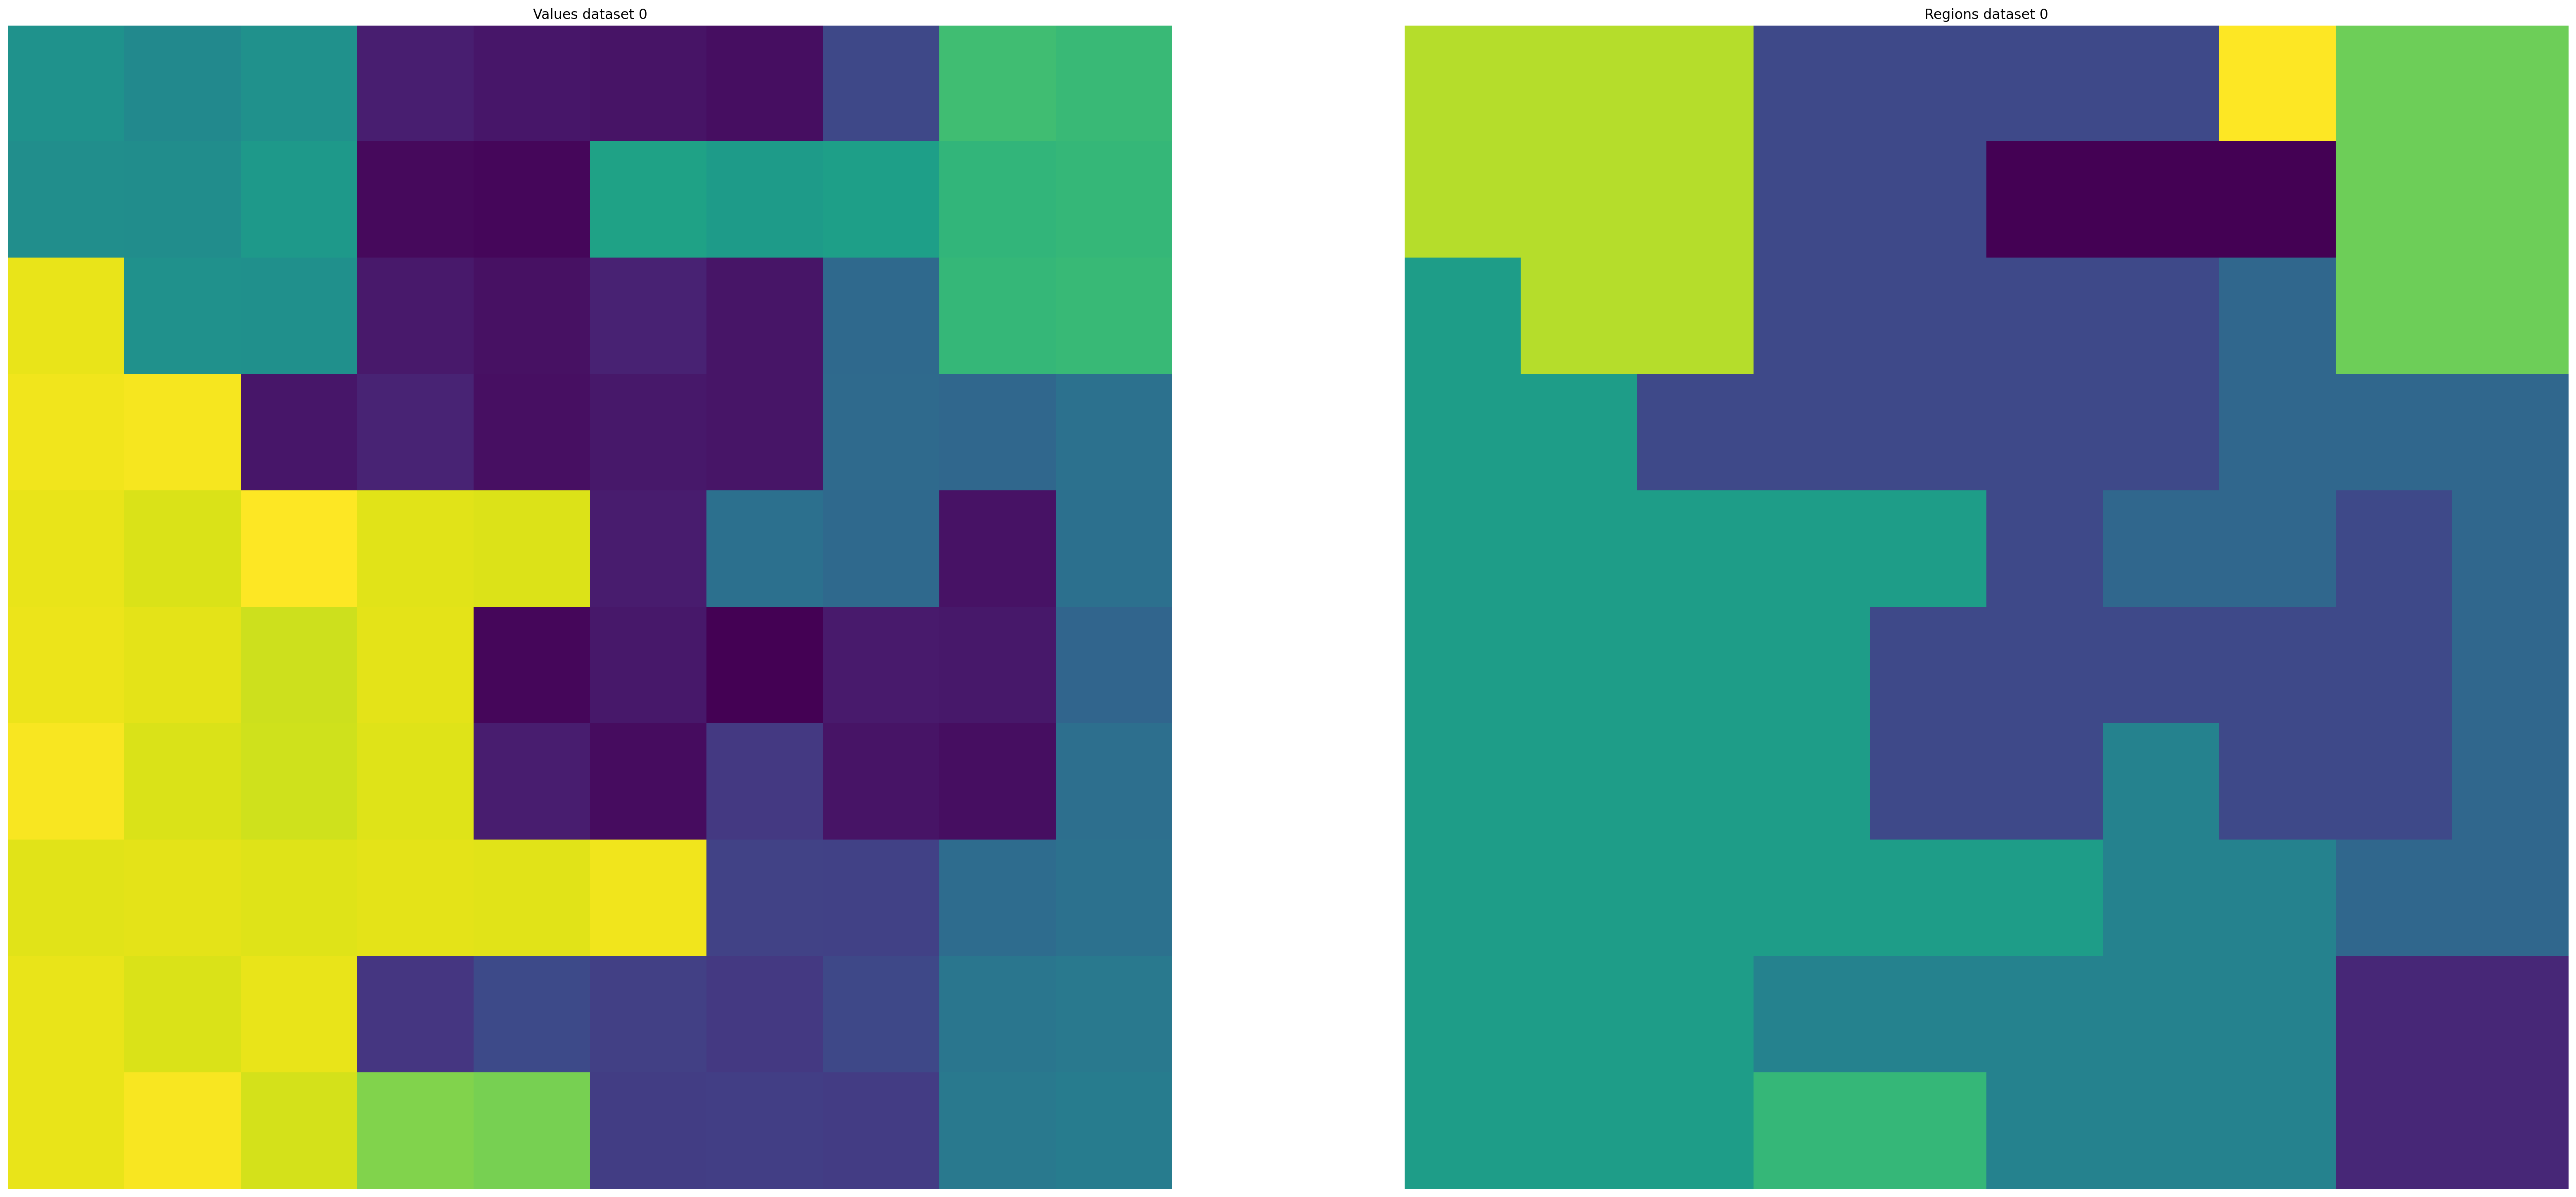

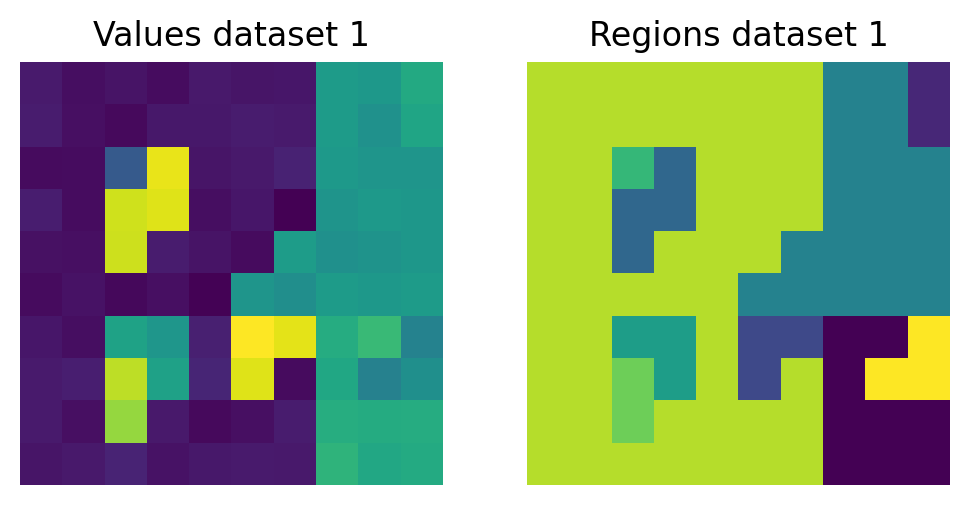

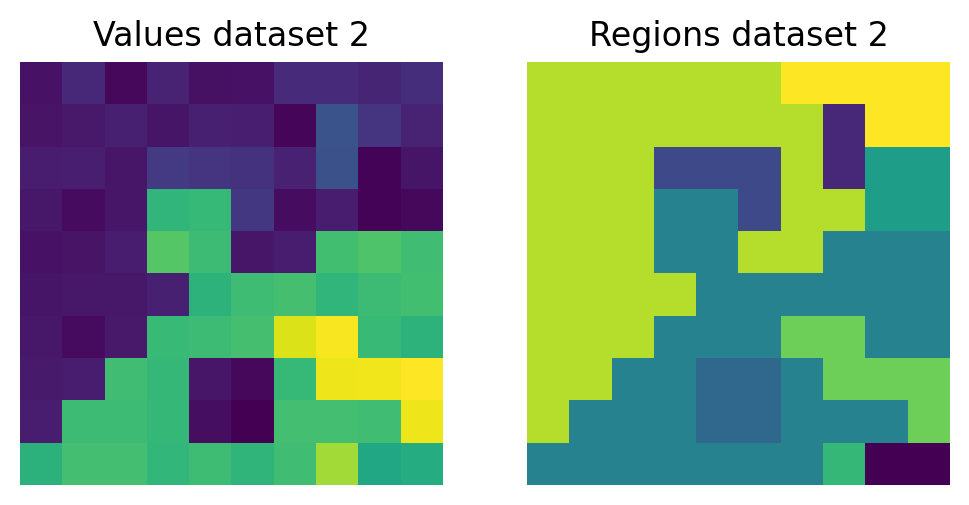

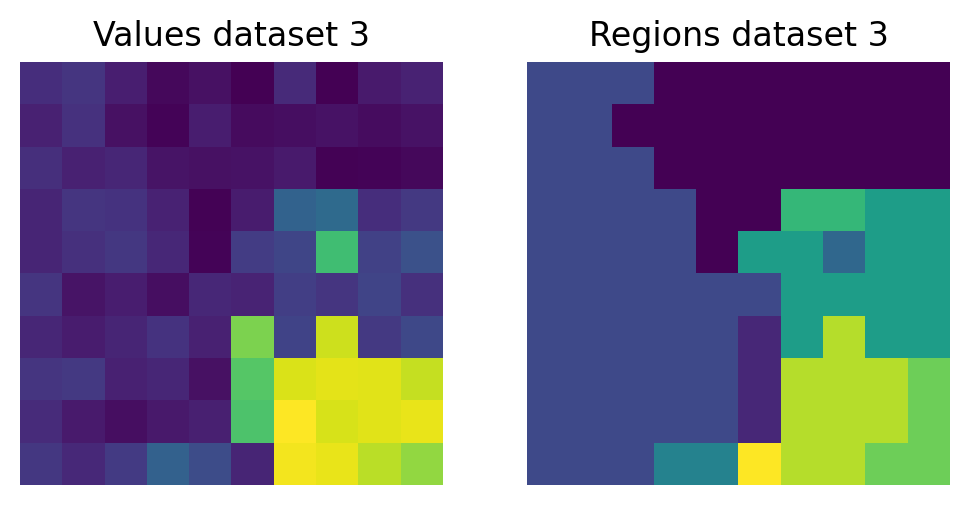

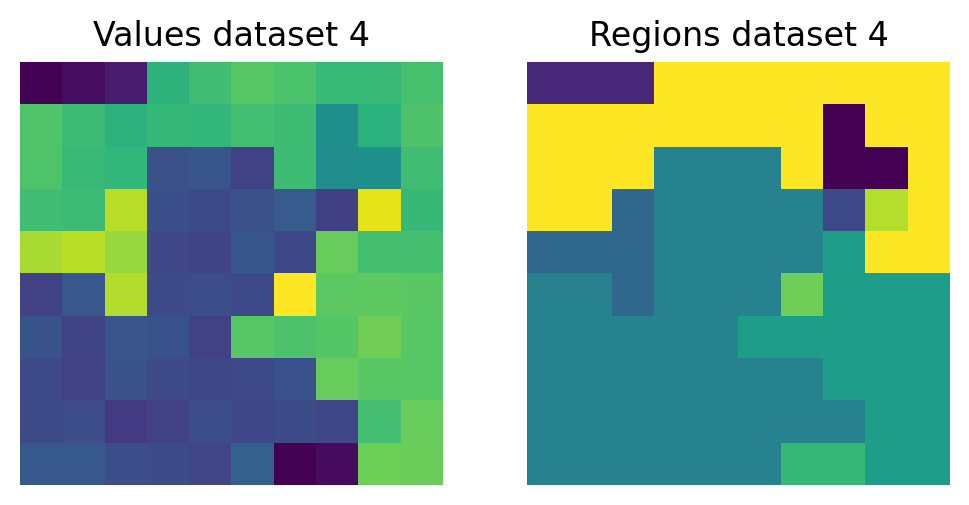

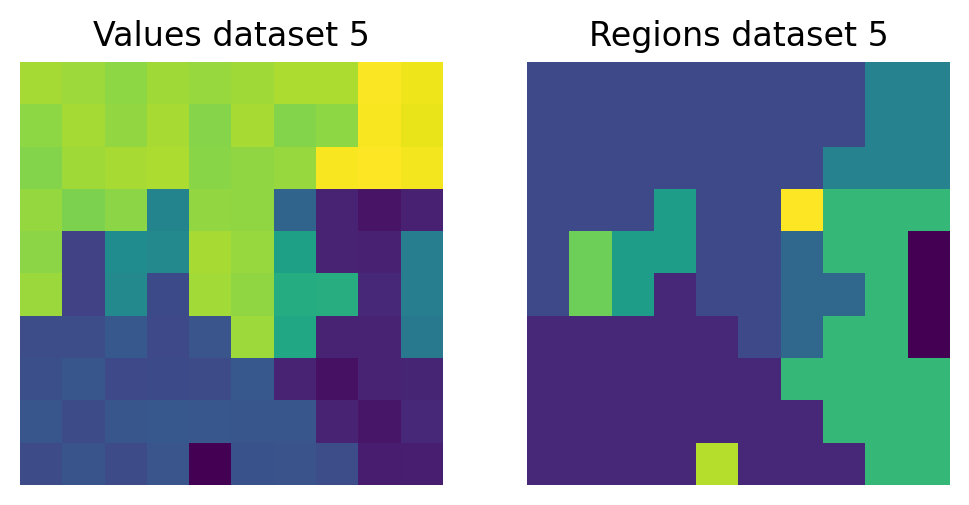

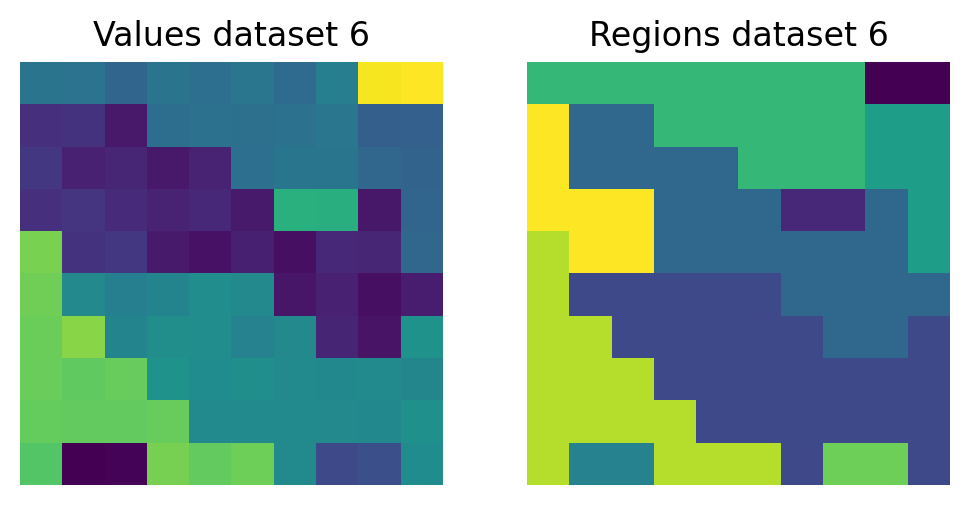

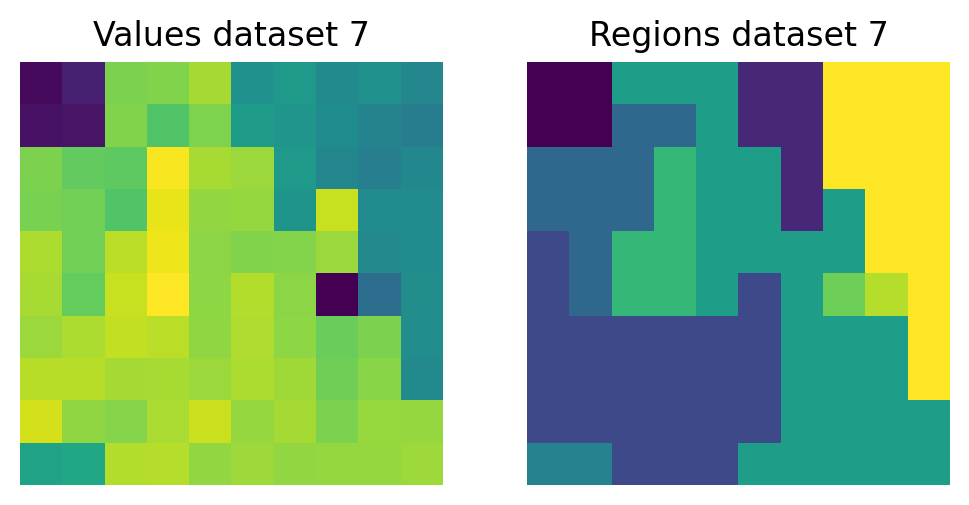

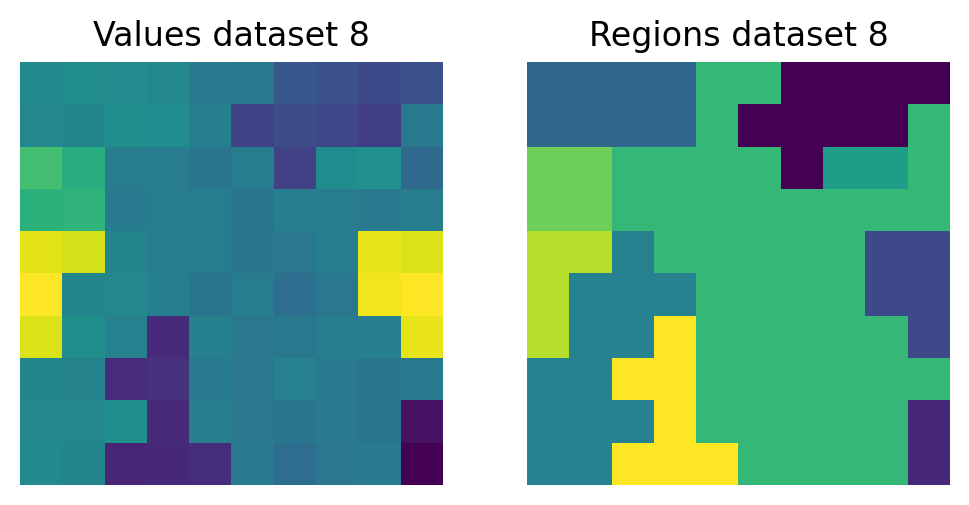

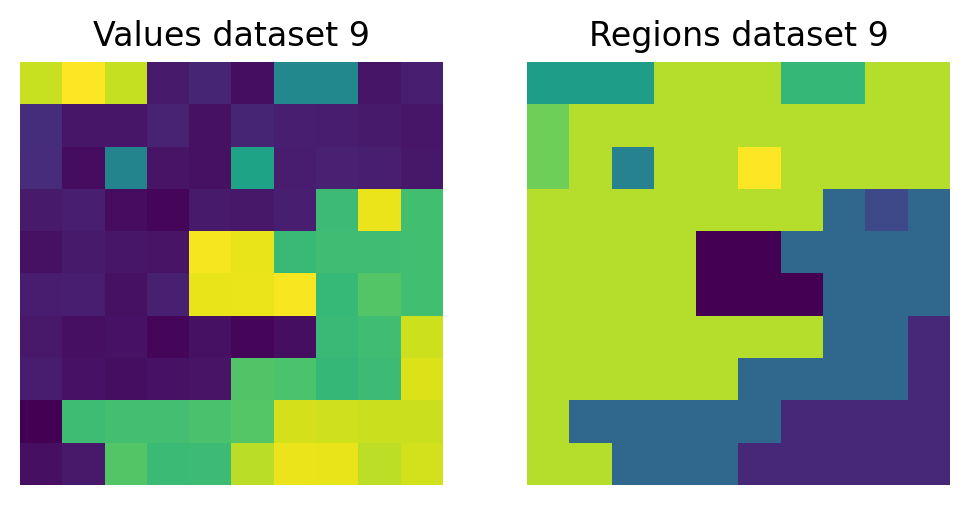

In [5]:
k,size,n_centers,delta,n = 10,10,40,2,10
datasets = []
plt.rcParams['figure.dpi'] = 200
plt.figure(figsize=(40,40))
for i in range(n):
    df = pd.read_pickle('./data/artificial_datasets/size{}_k{}_centers{}_delta{}_{}.pkl'.format(size,k,n_centers,delta,i))
    datasets.append(df)
    val = df['val'].values.reshape((size,size))
    regions = df['region'].values.reshape((size,size))
    
    plt.subplot(1,2,1)
    plt.imshow(val)
    plt.title('Values dataset {}'.format(i))
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.imshow(regions)
    plt.title('Regions dataset {}'.format(i))
    plt.axis('off')
    plt.show()

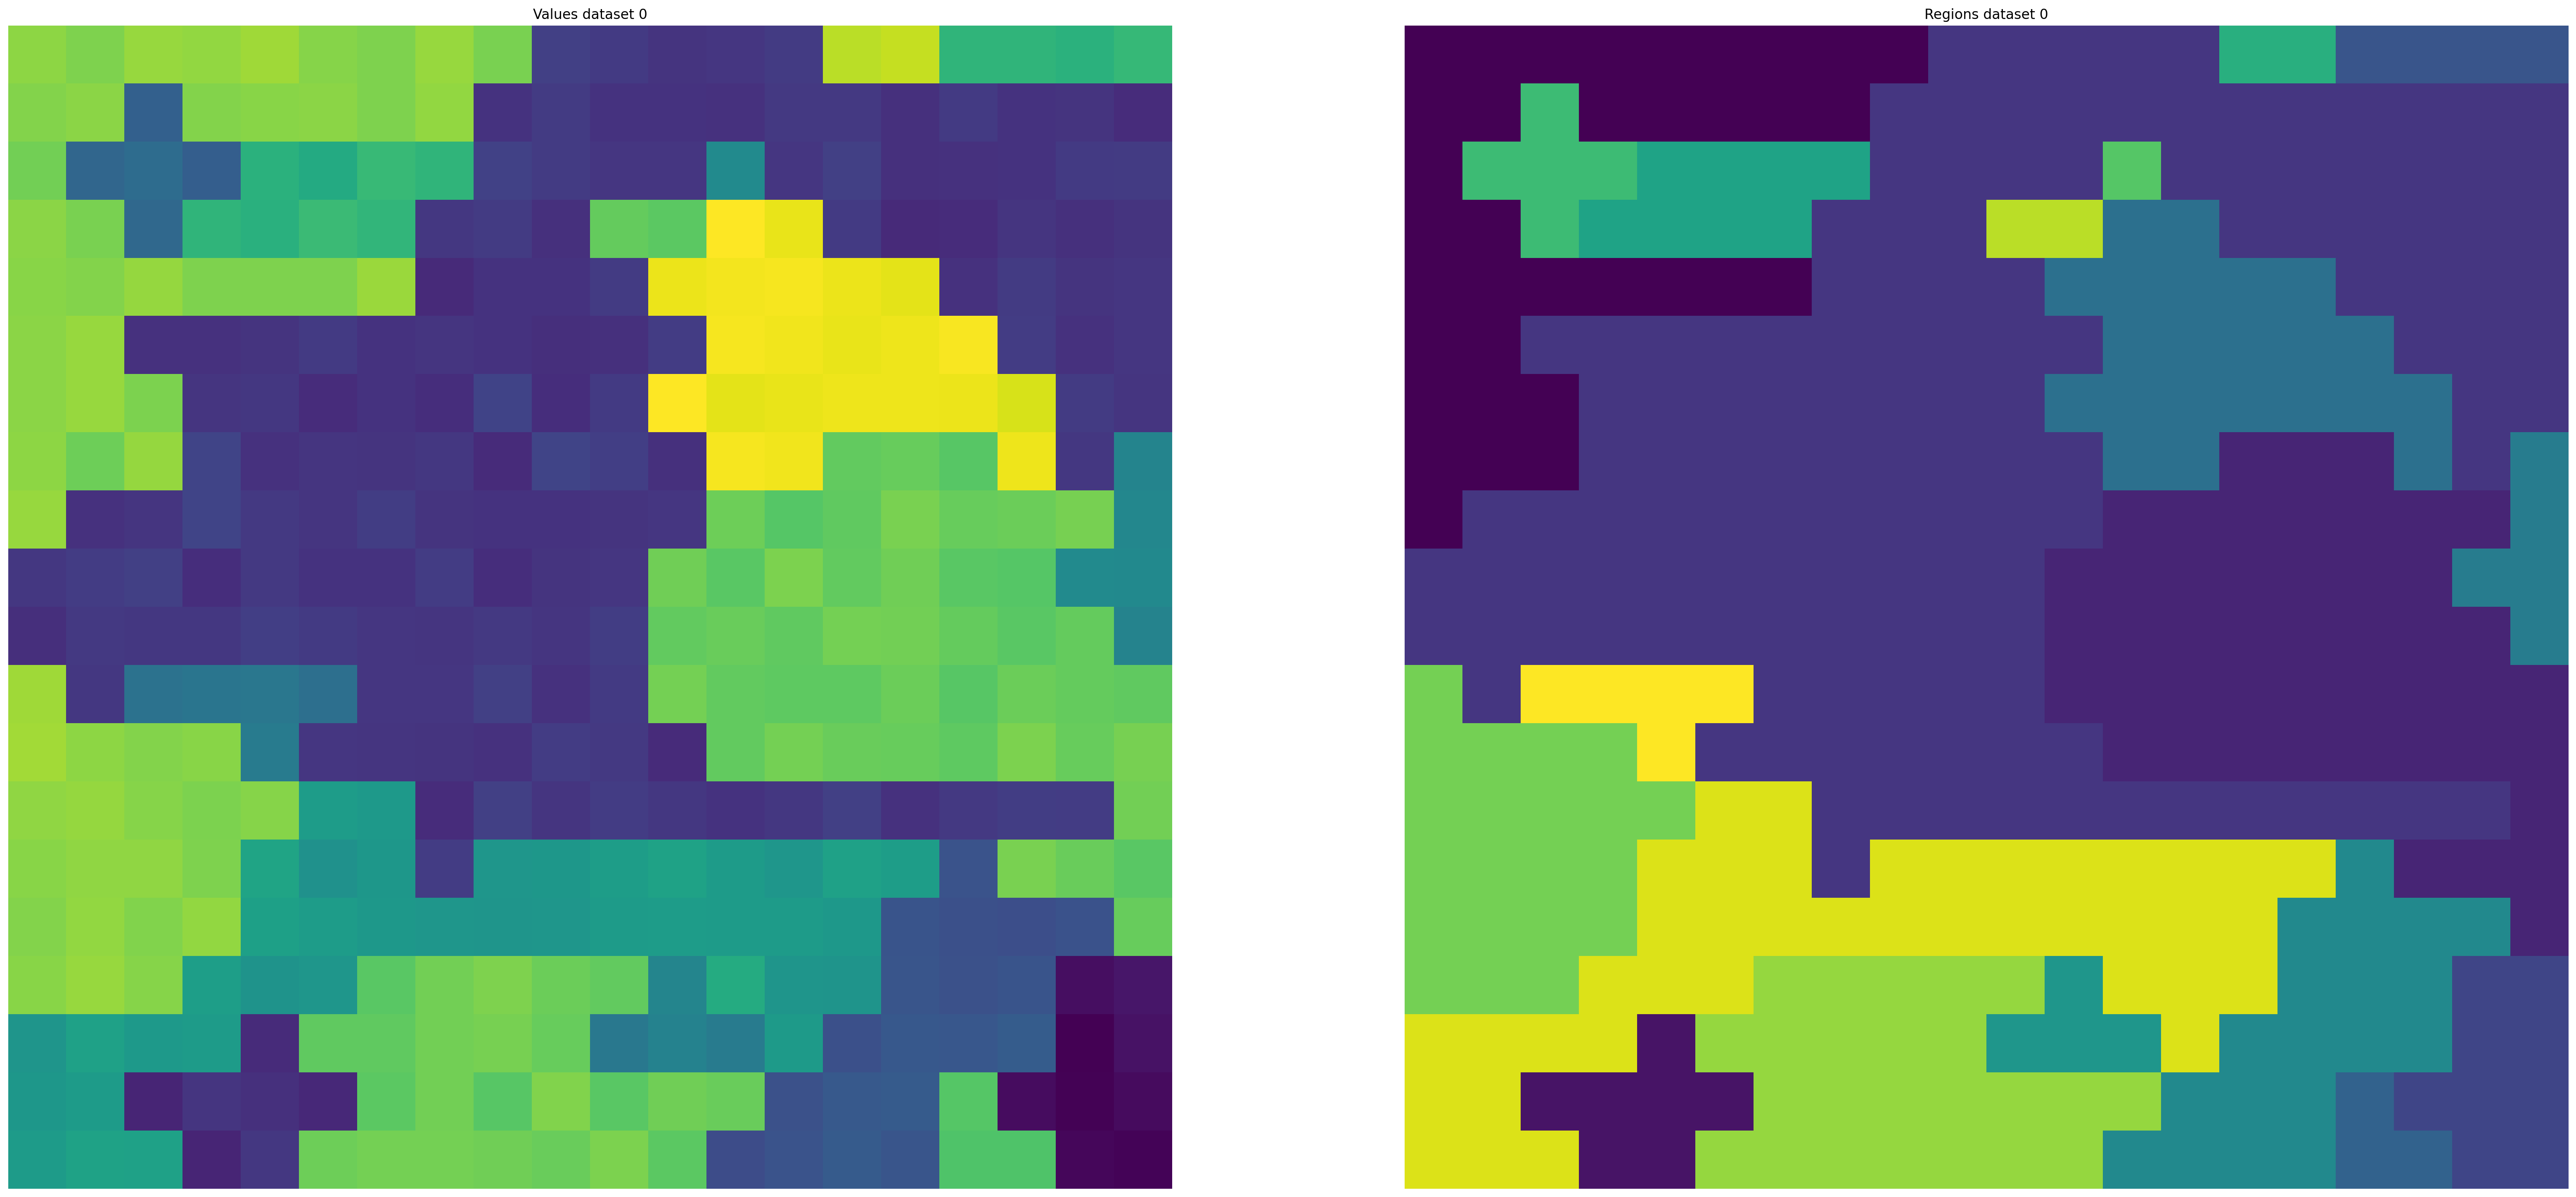

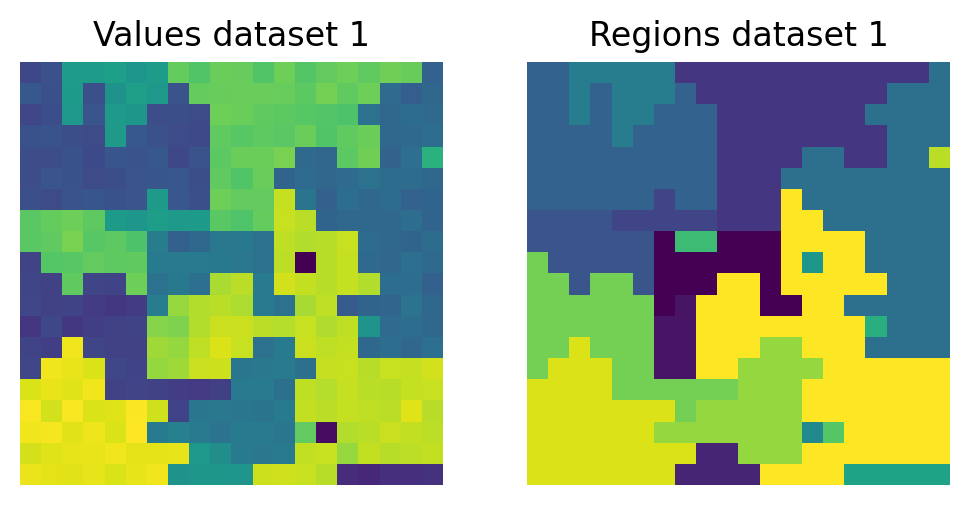

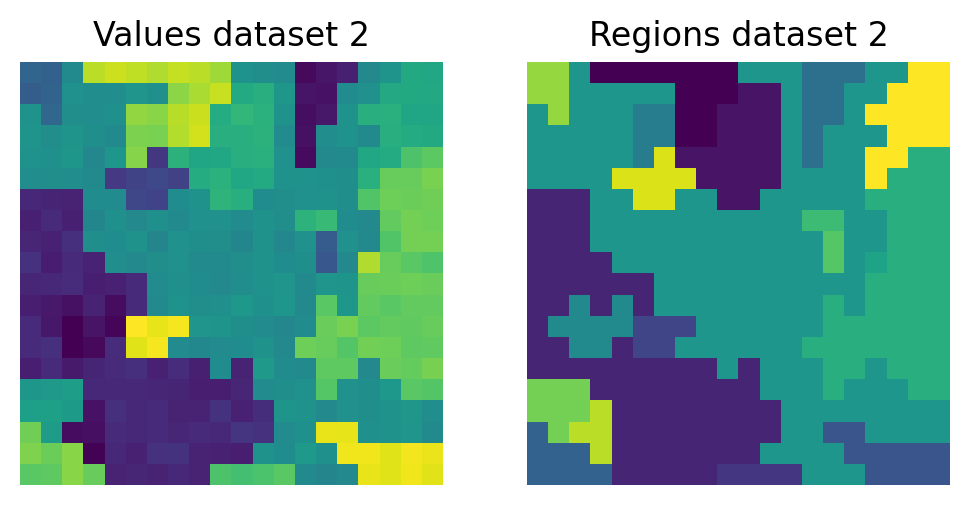

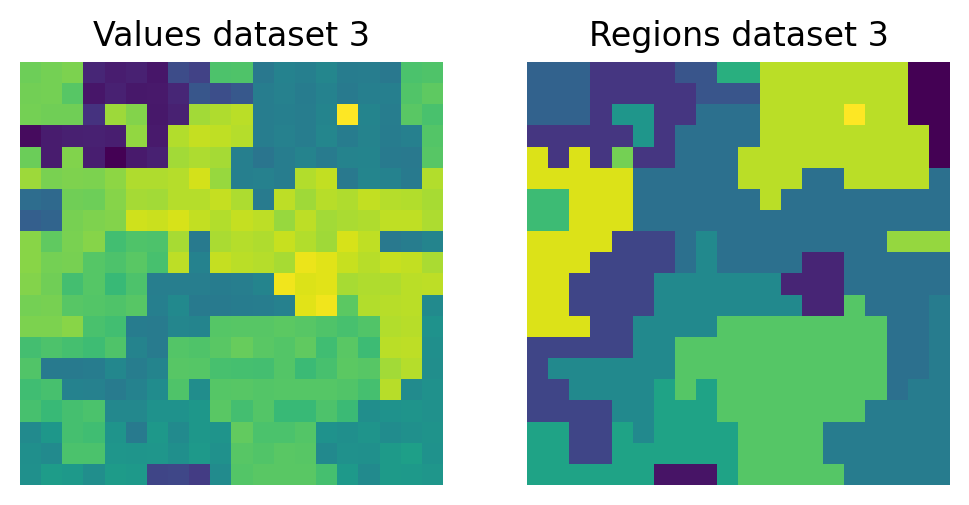

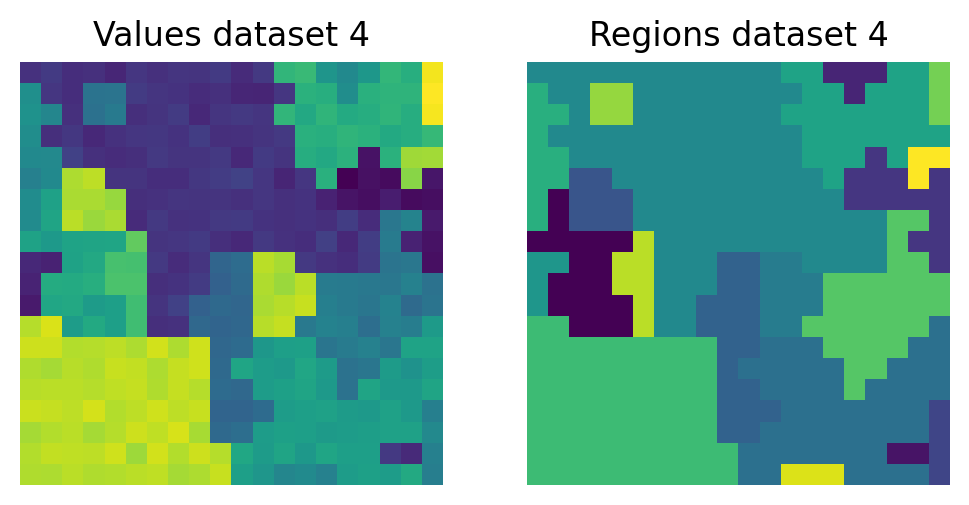

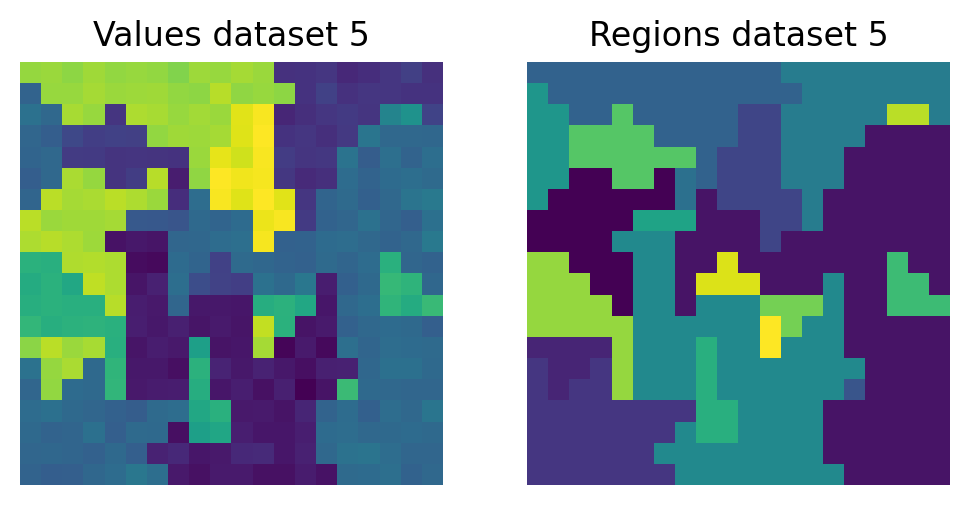

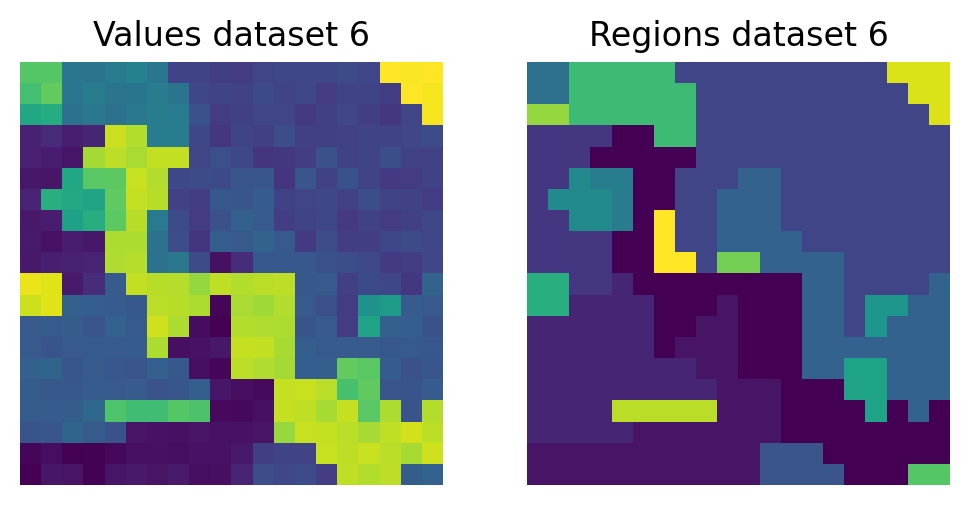

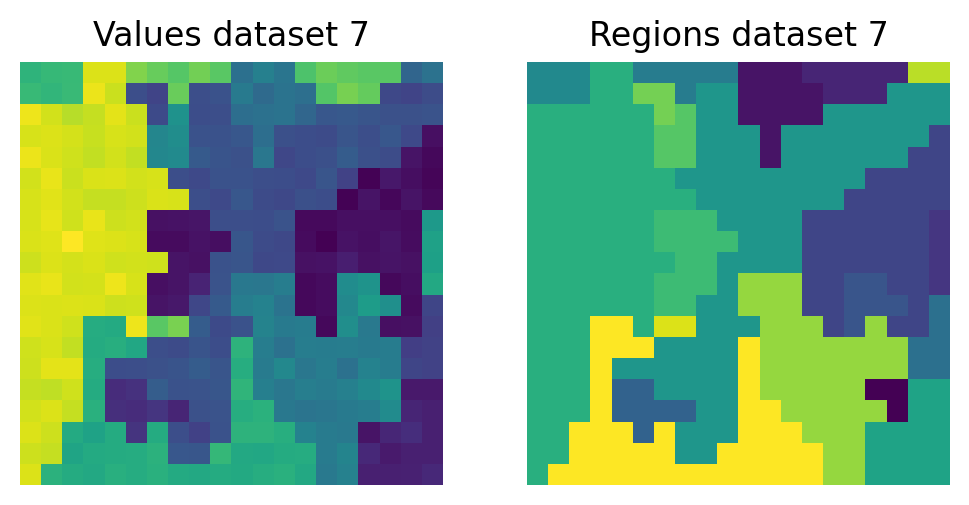

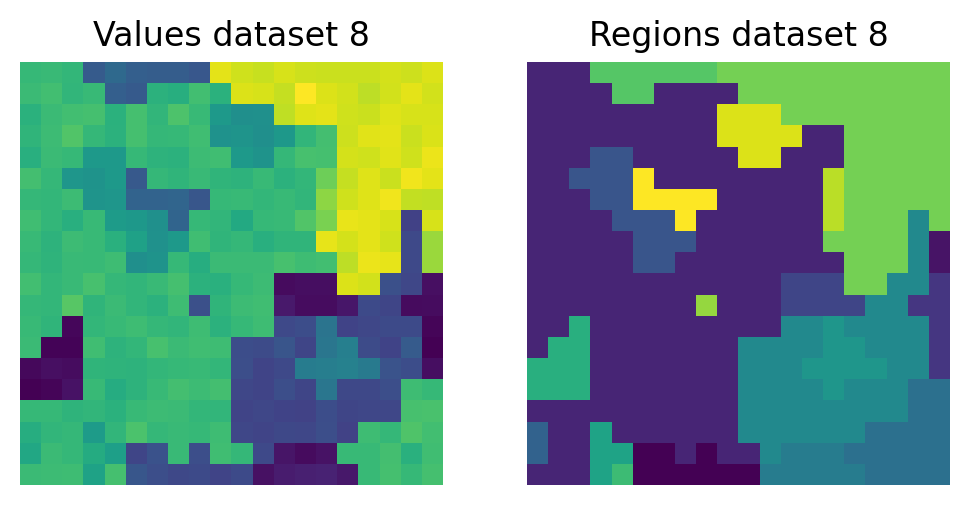

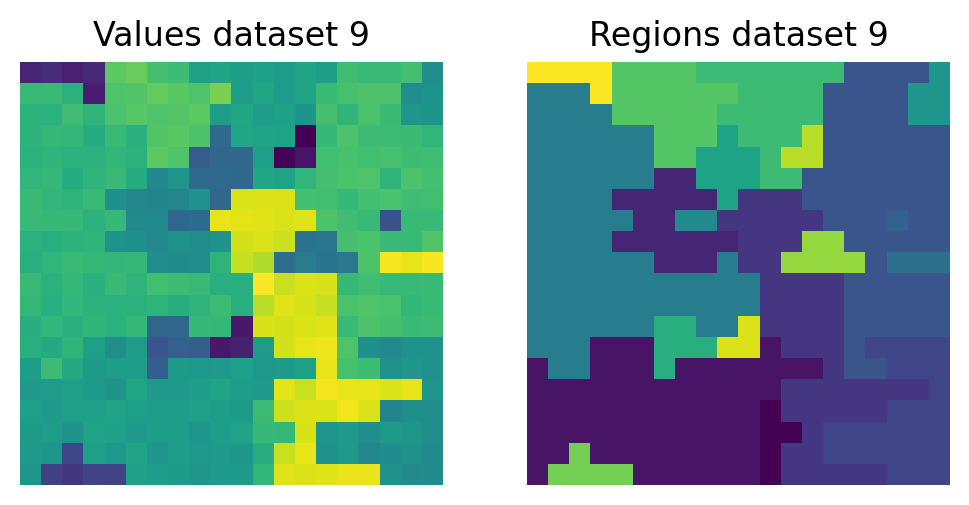

In [6]:
k,size,n_centers,delta,n = 20,20,80,4,10
datasets = []
plt.rcParams['figure.dpi'] = 200
plt.figure(figsize=(40,40))
for i in range(n):
    df = pd.read_pickle('./data/artificial_datasets/size{}_k{}_centers{}_delta{}_{}.pkl'.format(size,k,n_centers,delta,i))
    datasets.append(df)
    val = df['val'].values.reshape((size,size))
    regions = df['region'].values.reshape((size,size))
    
    plt.subplot(1,2,1)
    plt.imshow(val)
    plt.title('Values dataset {}'.format(i))
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.imshow(regions)
    plt.title('Regions dataset {}'.format(i))
    plt.axis('off')
    plt.show()

In [22]:
dist_m = []
for i in range(n):
    df = pd.read_pickle('./data/artificial_datasets/size{}_k{}_centers{}_delta{}_{}_dist.pkl'.format(size,k,n_centers,delta,i))
    dist_m.append(df)
cont_m = pd.read_pickle('./data/artificial_datasets/size{}_cont.pkl'.format(size))

In [24]:
list(datasets[0]['region'])

[6.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 6.0,
 7.0,
 6.0,
 7.0,
 7.0,
 0.0,
 0.0,
 0.0,
 7.0,
 7.0,
 6.0,
 6.0,
 6.0,
 7.0,
 7.0,
 0.0,
 0.0,
 0.0,
 0.0,
 8.0,
 6.0,
 6.0,
 6.0,
 9.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 6.0,
 5.0,
 9.0,
 9.0,
 9.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 6.0,
 5.0,
 5.0,
 9.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.0,
 0.0,
 5.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 4.0,
 3.0,
 3.0,
 3.0,
 3.0,
 2.0,
 2.0,
 2.0,
 4.0,
 4.0,
 4.0,
 3.0,
 3.0,
 3.0,
 3.0,
 2.0,
 2.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0]